# The Demographics Of Census Nonresponses In Your Region

### By Benjamin Livingston, [*NewsCounts*](http://newscounts.org)

### April 13, 2020

# Introduction

"Undercounted" is a popular buzzphrase as the 2020 US Census takes shape - but what does it mean for your region?

*NewsCounts* has built a workflow that will allow you to quantify this like never before - **and we're prepared to tailor it for your newsroom using both 2010 data and up-to-date 2020 data.** 

Think of this as an **easy, virtually instant template** for a compelling story on demographics and census response rates in your region. 

##  Three Easy Steps to Visualizing Census Response Rates

### 1. Examine Factors Nationally

We'll start by examining which socioeconomic factors correlated with undercounts in 2010, and then compare it to what appears to be happening in 2020.

To do this, we will look at basic tract-level data from the 2010 decennial census and five-year American Community Survey estimates from 2010 and 2018, and use them as a means of modeling *why* America's 50 states (plus the District of Columbia) seemed to get undercounted in 2010, and seem to be getting undercounted in 2020.

### 2. Examine Factors Locally

We'll then move to a more granular analysis that demonstrates how that national story on response rates might change in your local area, and how you can tell that story.

### 3. Adapt For Your Newsroom 

It's **very** easy to take this analysis and adapt it for your local area.

We'll show a few examples of particularly interesting case studies here, pretending we're in local newsrooms in a few different parts of the country.

**Keep in mind: we can help you run this analysis for your own state or county in literally a matter of seconds** - see the end of this article for contact details (all we have to do is add one line of code!).

Email me *any* time at [benjamin.livingston@columbia.edu](mailto:benjamin.livingston@columbia.edu) if you'd like to see the data for your region visualized like this. Whether you're a data expert or you've never heard of a spreadsheet, *NewsCounts* will make it quick and easy for you.

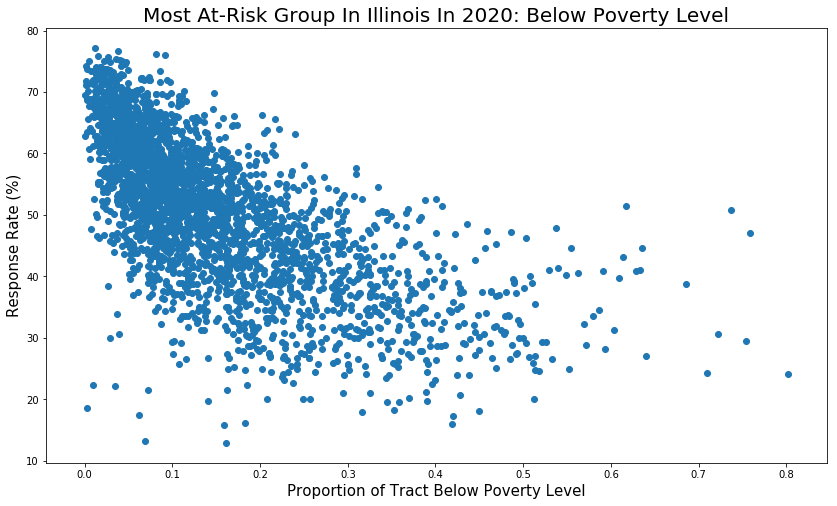

# 1. National Results

We now present the factors that correlated most with undercounting in 2010. 

**No coding or mathematical experience is necessary to understand the below results**, but we left our source code in for the more technically-minded.

Technical details and a glossary are available [here](#Appendix:-Technical-Details) for those interested.

In [1]:
# import packages
import pandas as pd
import numpy as np
import math as m
import requests
import json
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
import string
import warnings
warnings.filterwarnings('ignore')

# set API key 
key = '2988f01f5e86175bda8beae2b5035e1ccef2d052'

# tested shortcut for obtaining state FIPS codes
url = f"https://api.census.gov/data/2010/dec/responserate?get=GEO_ID,FSRR2010&key={key}&for=state:*"
JSONContent = requests.get(url).json()
states = pd.DataFrame(JSONContent)
states = states.iloc[1:,2]
states = [int(i) for i in states if i !='72']
states = sorted(states)

# pull 2010 mail response rates for each state and concatenate
columns=['GEO_ID','FSRR2010']
responses = pd.DataFrame(columns=columns)
for i in states:
    if i < 10:
        url = f"https://api.census.gov/data/2010/dec/responserate?get=GEO_ID,FSRR2010&key={key}&for=tract:*&in=state:0"\
        + str(i)
    else:
        url = f"https://api.census.gov/data/2010/dec/responserate?get=GEO_ID,FSRR2010&key={key}&for=tract:*&in=state:"\
        + str(i)       
    JSONContent = requests.get(url).json()        
    temp = pd.DataFrame(JSONContent)
    temp = temp.iloc[1:,[0,1]]
    temp.columns = columns
    responses = pd.concat([responses,temp])

# get 2010 decennial census numbers
url_base = f'https://api.census.gov/data/2010/dec/sf1?get=\
GEO_ID,P001001,P002005,P003002,P003003,P003004,\
P003005,P003006,P003007,P003008,P004003&key={key}&for=tract:*&in=state:'
url = url_base + '01'
JSONContent = requests.get(url).json()
temp = pd.DataFrame(JSONContent)
columns = temp.iloc[0,:-3]
dec_demos = pd.DataFrame(columns = columns)
for i in states:
    if i<10:
        url = url_base + '0' + str(i)
    else:
        url = url_base + str(i)

    JSONContent = requests.get(url).json()
    temp = pd.DataFrame(JSONContent)
    temp = temp.iloc[1:,:-3]
    temp.columns=columns
    dec_demos = pd.concat([dec_demos,temp])

# get 2010 five-year ACS averages to fill in data gaps
url_base = f'https://api.census.gov/data/2010/acs/acs5?get=GEO_ID,\
B05001_006E,B06007_033E,\
B06009_002E,B17001_002E,B06010_011E&key={key}&for=tract:*&in=state:'
url = url_base + '01'
JSONContent = requests.get(url).json()
temp = pd.DataFrame(JSONContent)
columns = temp.iloc[0,:-3]
acs_demos = pd.DataFrame(columns = columns)
for i in states:
    if i<10:
        url = url_base + '0' + str(i)
    else:
        url = url_base + str(i)
    
    JSONContent = requests.get(url).json()   
    temp = pd.DataFrame(JSONContent)
    temp = temp.iloc[1:,:-3]
    temp.columns=columns
    acs_demos = pd.concat([acs_demos,temp])

# set GEO_ID as index
dec_demos.index = dec_demos.GEO_ID
dec_demos = dec_demos.drop(columns='GEO_ID')
acs_demos.index = acs_demos.GEO_ID
acs_demos = acs_demos.drop(columns='GEO_ID')
responses.index = responses.GEO_ID
responses = responses.drop(columns='GEO_ID')

# merge response rates, ACS, and decennial data
data = responses.merge(dec_demos,how='inner',left_index=True,right_index=True)
data = data.merge(acs_demos,how='inner',left_index=True,right_index=True)
data = data[data.FSRR2010.notna()]

# rename columns
data.columns = ['response','population','rural','white',\
                'black','AIAN','asian','pacific_islander',\
                'other_race','multiracial','hispanic','noncitizen',\
               'foreign_born','no_high_school',\
               'below_poverty_level','make_over_75k']

# change data to float
data = data.astype('float32')

# remove zero population areas
data = data[data.population > 0]

# normalize by population
for column in data.columns:
    if column not in ['population','response']:
        data[column] = data[column]/data['population']

# pull data from 2018 ACS
url_base = 'https://api.census.gov/data/2018/acs/acs5?get=B01003_001E,B02001_002E,B02001_003E,B02017_001E,'\
        +'B02001_005E,B02001_006E,B02001_007E,B02001_008E,B03002_012E,B05001_006E,B99051_005E,'\
        +f'B17001_002E,B07010_011E,B06009_002E,GEO_ID&key={key}&for=tract:*&in=state:'
url = url_base + '01'
JSONContent = requests.get(url).json()
temp = pd.DataFrame(JSONContent)
columns = temp.iloc[0,:]
data_2020 = pd.DataFrame(columns=columns)

for i in states:
    if i < 10:
        url = url_base + '0' + str(i)
    else:
        url = url_base + str(i)
    try:
        JSONContent = requests.get(url).json()
        temp = pd.DataFrame(JSONContent)
        temp.columns = temp.iloc[0]
        temp = temp.iloc[1:,:]
        data_2020 = pd.concat([data_2020,temp])
    except json.JSONDecodeError:
        pass
    
# rename columns
data_2020.columns = ['population','white','black','AIAN','asian','pacific_islander',\
'other_race','multiracial','hispanic','noncitizen','foreign_born','below_poverty_level',\
'make_over_75k','no_high_school','GEO_ID','county','state','tract']

# set GEO_ID as index
data_2020.index=data_2020.GEO_ID

# drop extra columns
data_2020 = data_2020.drop(columns=['county','state','tract','GEO_ID'])

# parse population to float
data_2020.population = data_2020.population.astype('float')

# remove zero population areas
data_2020 = data_2020[data_2020.population > 0]

# parse demographic data to float and normalize by population
for column in data_2020.columns:
    if column is not 'population':
        data_2020[column] = data_2020[column].astype('float')
        data_2020[column] = data_2020[column] / data_2020['population']

# data frame to hold tract responses
tract_responses = pd.DataFrame(columns=['GEO_ID','CRRALL'])

# pull tract response data for 2020
for i in states:
    if i < 10:
        url = f"https://api.census.gov/data/2020/dec/responserate?get=GEO_ID,CRRALL&key={key}&for=tract:*&in=state:0"\
        + str(i)
    else:
        url = f"https://api.census.gov/data/2020/dec/responserate?get=GEO_ID,CRRALL&key={key}&for=tract:*&in=state:"\
        + str(i)
    try:
        JSONContent = requests.get(url).json()
        temp = pd.DataFrame(JSONContent).iloc[:,0:2]
        temp.columns = temp.iloc[0]
        temp = temp.iloc[1:,:]
        tract_responses = pd.concat([tract_responses,temp],sort=True)
    except json.JSONDecodeError:
        pass

# set index and column title for 2020 response rates
tract_responses['CRRALL'] = tract_responses['CRRALL'].astype('float')
tract_responses.index = tract_responses.GEO_ID
tract_responses = tract_responses.drop(columns = 'GEO_ID')
tract_responses.columns = ['response']

# merge demographic data and response data
data_2020 = pd.merge(data_2020,tract_responses,'inner','GEO_ID')

# create copy of original 2010 data
original_data = data.copy()

# use proportion of rural population from 2010 to approximate the same for 2020 
data_2020['rural'] = original_data['rural']

# eliminate 2020 tracts that do not match tracts from 2010
data_2020 = data_2020[pd.notnull(data_2020.rural)]

# remove five tracts that had null values for two variables
data_2020 = data_2020[pd.notnull(data_2020.make_over_75k)] 
data_2020 = data_2020[pd.notnull(data_2020.below_poverty_level)] 

# create copy of original 2020 data
original_data_2020 = data_2020.copy()

# create dataset for 2010
X_train = original_data.drop('response',axis=1)
y_train = original_data.response
                         
# fit tree model for 2010
tree_2010 = DecisionTreeRegressor()
tree_2010.fit(X_train,y_train)
 
# generate correlations & tree importances for 2010
correlations_2010 = list(original_data.corr()['response'].drop(index='response'))
tree_importances_2010 = list(tree_2010.feature_importances_)

# create dataset for 2020
X_train = original_data_2020.drop('response',axis=1)
y_train = original_data_2020.response

# fit tree model for 2020
tree_2020 = DecisionTreeRegressor()
tree_2020.fit(X_train,y_train)

# generate correlations & tree importances for 2010
correlations_2020 = list(original_data_2020.corr()['response'].drop(index='response'))
tree_importances_2020 = list(tree_2020.feature_importances_)

# concatenate results from 2010
results_2010 = pd.DataFrame(data=[correlations_2010,tree_importances_2010],\
             columns=list(data.drop('response',axis=1).columns),\
             index=['correlations_2010','tree_importances_2010'])
results_2010 = results_2010.transpose().round(2)

# concatenate results from 2020
results_2020 = pd.DataFrame(data=[correlations_2020,tree_importances_2020],\
             columns=list(data_2020.drop('response',axis=1).columns),\
             index=['correlations_2020','tree_importances_2020'])
results_2020 = results_2020.transpose().round(2)

# add dummy column
dummy_col = pd.Series(['---------------------'] * results_2020.shape[0],index=results_2010.index,name='---------------------')

# assemble full results
full_results = pd.merge(results_2010,dummy_col,'inner',left_index=True,right_index=True)
full_results = pd.merge(full_results,results_2020,'inner',left_index=True,right_index=True)
full_results = full_results.iloc[:,[0,3,2,1,4]]
full_results = full_results.reindex(full_results.correlations_2010.abs().sort_values(ascending=False).index)

bootstrapped_correlations = np.zeros((1000,original_data.shape[1]-1))
for i in range(1000):
    bootstrapped_correlations[i] = list(original_data.sample(frac=1,replace=True).corr()['response'].drop(index='response'))
bootstrap = pd.DataFrame(bootstrapped_correlations,columns = original_data.corr()['response'].drop(index='response').index)

correlations_2020 = original_data_2020.corr()['response'].drop(index='response')

pvals = pd.Series(name='Bootstrap P-value of Change in Correlation From 2010 to 2020')
for index in correlations_2020.index:
    pvals[index] = np.mean(bootstrap[index].to_numpy() <= correlations_2020[index])
p_results = pvals.copy()
p_results = p_results.astype('str')
p_results[pvals<.025] = 'Decreased'
p_results[pvals>.975] = 'Increased'
pvals.loc[pvals>.5] = 1 - pvals.loc[pvals>.5]
p_results[pvals>=.025] = 'No Change'

pvals_df = pd.DataFrame(pvals)
pvals_df['Conclusion From P-Value'] = p_results
pvals_df = pvals_df.reindex(full_results.correlations_2010.abs().sort_values(ascending=False).index)

,correlations_2010,correlations_2020,---------------------,tree_importances_2010,tree_importances_2020
below_poverty_level,-0.46,-0.53,---------------------,0.27,0.34
make_over_75k,0.38,0.48,---------------------,0.08,0.10
no_high_school,-0.37,-0.50,---------------------,0.05,0.07
white,0.36,0.29,---------------------,0.07,0.05
black,-0.34,-0.27,---------------------,0.06,0.03
population,0.26,0.27,---------------------,0.10,0.08
other_race,-0.19,-0.24,---------------------,0.04,0.02
noncitizen,-0.16,-0.25,---------------------,0.04,0.04
hispanic,-0.16,-0.27,---------------------,0.06,0.05
AIAN,-0.15,-0.17,---------------------,0.05,0.04


,Bootstrap P-value of Change in Correlation From 2010 to 2020,Conclusion From P-Value
below_poverty_level,0.000,Decreased
make_over_75k,0.000,Increased
no_high_school,0.000,Decreased
white,0.000,Decreased
black,0.000,Increased
population,0.099,No Change
other_race,0.000,Decreased
hispanic,0.000,Decreased
noncitizen,0.000,Decreased
AIAN,0.000,Decreased


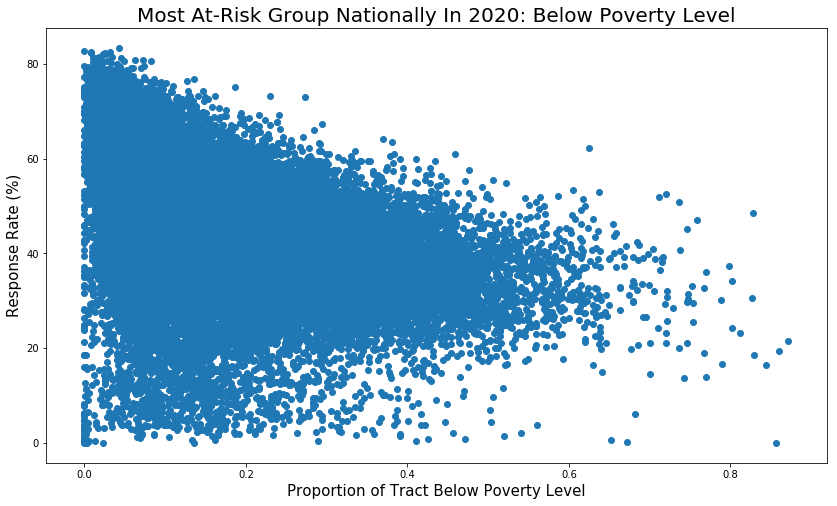

In [2]:
display(full_results)
display(pvals_df)

idx = full_results['correlations_2020'].idxmin()
group = string.capwords(idx.replace('_',' '))
plot = plt.figure(figsize=(14,8))
plt.title('Most At-Risk Group Nationally In 2020: ' + group,size=20)
plt.xlabel('Proportion of Tract ' + group,size=15)
plt.ylabel('Response Rate (%)',size=15)
plt.scatter(data_2020[idx],data_2020['response'])

### Methodology 

To accomplish our goal, we used two very simple models that allow us to glean which demographic factors correlate most with higher response rates:
* A linear model that calculates the correlation between response rates and each demographic factor independently
* A tree model that puts heavier emphasis on the factors that have the biggest impact in determining why areas are undercounted

We'll present the weights from these models to determine which demographic factors are most pivotal (more details [here](#Appendix:-Technical-Details)).

### National Findings

Examining the national results, it is abundantly clear across the board that socioeconomic factors correlate heavily with undercounting.

We find a fairly substantial positive correlation between higher income and a higher likelihood of filling out a census form, and the white- and Asian-heavy areas are filling out census forms more frequently than areas with more African-Americans, Hispanics, and native populations.

More populous, urban areas had higher return rates, as did areas with more minors.

While things appear to have changed significantly for nearly every group since 2010, it appears that Hispanic- and non citizen-heavy areas are replying at a noticeably lower clip in 2020, which many feared after the White House's attempt to [add a citizenship question](https://www.nytimes.com/2019/07/02/us/trump-census-citizenship-question.html) to this year's census.

It also appears that areas with fewer high-school educated residents and more impoverished residents tend to respond at a lower rate in 2020 than they did in 2010.

Meanwhile, it appears areas that have more African-Americans are still being undercounted, but this data suggests that perhaps those issues are, on the average, not quite as bad as in 2010. 

Our tree model identified economic status as the most important factor in predicting response rates - but it's possible that it is simply a proxy for more granular socioeconomic differences.

We're only scratching the surface, though...

# 2. Local Case Studies

## Primary Case Study: Kansas

Let's say we're a newsroom in Topeka or Dodge City, and do this analysis for Kansas as a whole.

,correlations_2010,correlations_2020,---------------------,tree_importances_2010,tree_importances_2020
make_over_75k,0.55,0.64,---------------------,0.29,0.36
below_poverty_level,-0.50,-0.60,---------------------,0.11,0.17
no_high_school,-0.46,-0.60,---------------------,0.01,0.07
hispanic,-0.46,-0.48,---------------------,0.02,0.03
white,0.43,0.37,---------------------,0.12,0.03
other_race,-0.40,-0.40,---------------------,0.02,0.03
population,0.37,0.37,---------------------,0.26,0.06
noncitizen,-0.34,-0.42,---------------------,0.02,0.09
black,-0.34,-0.29,---------------------,0.02,0.02
multiracial,-0.31,-0.21,---------------------,0.01,0.03


,Bootstrap P-value of Change in Correlation From 2010 to 2020,Conclusion From P-Value
make_over_75k,0.002,Increased
below_poverty_level,0.077,No Change
hispanic,0.310,No Change
no_high_school,0.014,Decreased
white,0.089,No Change
other_race,0.427,No Change
population,0.443,No Change
black,0.079,No Change
noncitizen,0.062,No Change
multiracial,0.038,No Change


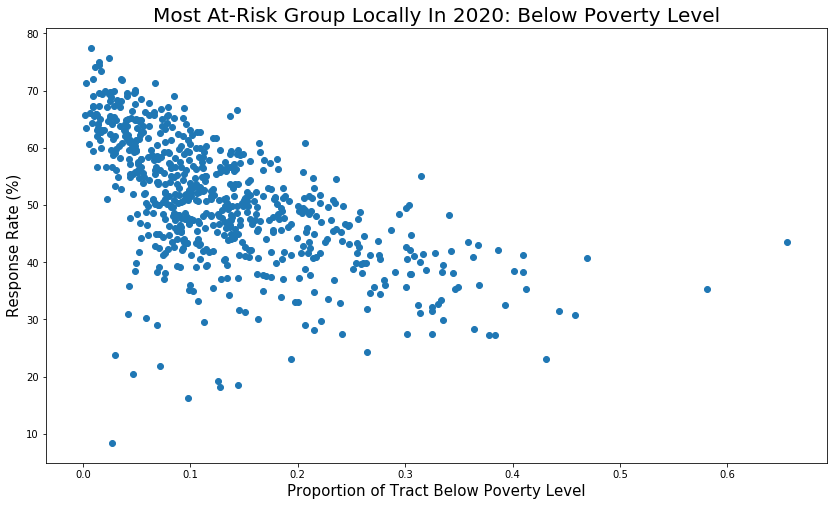

Total Number of Tracts Examined:  662


In [3]:
# function to filter down to results to one geographic area using numeric fips code
def show_area(fips):
    data = original_data.copy()
    data['GEO_ID'] = data.index
    data = data[data['GEO_ID'].str.contains('1400000US' + str(fips))]
    data = data.drop(columns='GEO_ID')
    state_2010 = data.copy()

    data = original_data_2020.copy()
    data['GEO_ID'] = data.index
    data = data[data['GEO_ID'].str.contains('1400000US' + str(fips))]
    data = data.drop(columns='GEO_ID')
    state_2020 = data.copy()

    # follow same steps as original analysis

    X_train = state_2010.drop('response',axis=1)
    y_train = state_2010.response

    tree_2010 = DecisionTreeRegressor()
    tree_2010.fit(X_train,y_train)

    correlations_2010 = list(state_2010.corr()['response'].drop(index='response'))
    tree_importances_2010 = list(tree_2010.feature_importances_)

    X_train = state_2020.drop('response',axis=1)
    y_train = state_2020.response

    tree_2020 = DecisionTreeRegressor()
    tree_2020.fit(X_train,y_train)

    correlations_2020 = list(state_2020.corr()['response'].drop(index='response'))
    tree_importances_2020 = list(tree_2020.feature_importances_)

    results_2010 = pd.DataFrame(data=[correlations_2010,tree_importances_2010],\
                 columns=list(state_2010.drop('response',axis=1).columns),\
                 index=['correlations_2010','tree_importances_2010'])

    results_2010 = results_2010.transpose().round(2)

    results_2020 = pd.DataFrame(data=[correlations_2020,tree_importances_2020],\
                 columns=list(state_2020.drop('response',axis=1).columns),\
                 index=['correlations_2020','tree_importances_2020'])

    results_2020 = results_2020.transpose().round(2)

    dummy_col = pd.Series(['---------------------'] * results_2020.shape[0],index=results_2010.index,name='---------------------')

    full_results = pd.merge(results_2010,dummy_col,'inner',left_index=True,right_index=True)
    full_results = pd.merge(full_results,results_2020,'inner',left_index=True,right_index=True)
    full_results = full_results.iloc[:,[0,3,2,1,4]]
    full_results = full_results.reindex(full_results.correlations_2010.abs().sort_values(ascending=False).index)

    bootstrapped_correlations = np.zeros((1000,state_2010.shape[1]-1))
    for i in range(1000):
        bootstrapped_correlations[i] = list(state_2010.sample(frac=1,replace=True).corr()['response'].drop(index='response'))
    bootstrap = pd.DataFrame(bootstrapped_correlations,columns = original_data.corr()['response'].drop(index='response').index)

    correlations_2020 = state_2020.corr()['response'].drop(index='response')
    pvals = pd.Series(name='Bootstrap P-value of Change in Correlation From 2010 to 2020')
    for index in correlations_2020.index:
        pvals[index] = np.mean(bootstrap[index].to_numpy() <= correlations_2020[index])
    p_results = pvals.copy()
    p_results = p_results.astype('str')
    p_results[pvals<.025] = 'Decreased'
    p_results[pvals>.975] = 'Increased'
    pvals.loc[pvals>.5] = 1 - pvals.loc[pvals>.5]
    p_results[pvals>=.025] = 'No Change'

    pvals_df = pd.DataFrame(pvals)
    pvals_df['Conclusion From P-Value'] = p_results
    pvals_df = pvals_df.reindex(full_results.correlations_2010.abs().sort_values(ascending=False).index)

    display(full_results)
    display(pvals_df)
    
    idx = full_results['correlations_2020'].idxmin()
    group = string.capwords(idx.replace('_',' '))
    plt.figure(figsize=(14,8))
    plt.title('Most At-Risk Group Locally In 2020: ' + group,size=20)
    plt.xlabel('Proportion of Tract ' + group,size=15)
    plt.ylabel('Response Rate (%)',size=15)
    plt.scatter(state_2020[idx],state_2020['response'])
    plt.show()
    
    print('Total Number of Tracts Examined: ',min(state_2010.shape[0],state_2020.shape[0]))

show_area(20)

Here, we see socioeconomic differences having an even bigger impact. There's a massive divide in response rates between the rich and the poor areas, and the majority-heavy and minority-heavy communities. It does not appear that these divides have been assuaged at all since 2010.

It's pretty clear that Kansas' Hispanic and [extremely diverse](https://www.thekansan.com/news/20200119/students-flourish-in-garden-city-high-school-esl-classes) minority, foreign-born, and undocumented communities are much more frequently undercounted than its more affluent, white communities.

This is a [well-documented](https://www.dodgeglobe.com/news/20200207/we-dont-exist-in-push-for-dodge-city-complete-count-census-fears-threaten-resources) issue in Kansas - but this kind of analysis can give new weight to a news story about why a particular region might be undercounted by adding mathematical evidence.

Looking at the tree importances, we see an even clearer line in the sand between the rich and the poor than we saw at the national level. It seems that these disparities are even more pronounced in Kansas.

One other difference between Kansas and the United States as a whole is that we generally do not have enough evidence to say these relationships have changed significantly since 2010 in Kansas. This could be viewed as a negative in light of the divides not lessening despite the state's [complete count efforts](https://kansascounts.org/), or a positive in terms of the divides not significantly worsening despite the current political climate.

Let's continue with some more quick analyses for some other interesting areas.

## Other Quick Examples

Remember - **we can easily do this analysis for your area almost instantaneously** - email me any time at [benjamin.livingston@columbia.edu](mailto:benjamin.livingston@columbia.edu) if you'd like to see these results for your region, too.

[*NewsCounts*](http://newscounts.org) provides countless data & research resources that make telling these stories easy - just drop us a line and we'll be happy to help.

### Florida

,correlations_2010,correlations_2020,---------------------,tree_importances_2010,tree_importances_2020
below_poverty_level,-0.34,-0.47,---------------------,0.17,0.30
population,0.26,0.24,---------------------,0.17,0.12
white,0.25,0.24,---------------------,0.05,0.03
black,-0.24,-0.24,---------------------,0.04,0.06
no_high_school,-0.21,-0.40,---------------------,0.05,0.07
other_race,-0.20,-0.19,---------------------,0.05,0.03
make_over_75k,0.16,0.23,---------------------,0.06,0.08
asian,0.16,0.20,---------------------,0.07,0.03
AIAN,-0.14,-0.07,---------------------,0.04,0.04
rural,-0.13,-0.17,---------------------,0.01,0.03


,Bootstrap P-value of Change in Correlation From 2010 to 2020,Conclusion From P-Value
below_poverty_level,0.000,Decreased
population,0.143,No Change
white,0.245,No Change
black,0.403,No Change
no_high_school,0.000,Decreased
other_race,0.180,No Change
asian,0.052,No Change
make_over_75k,0.003,Increased
AIAN,0.000,Increased
rural,0.030,No Change


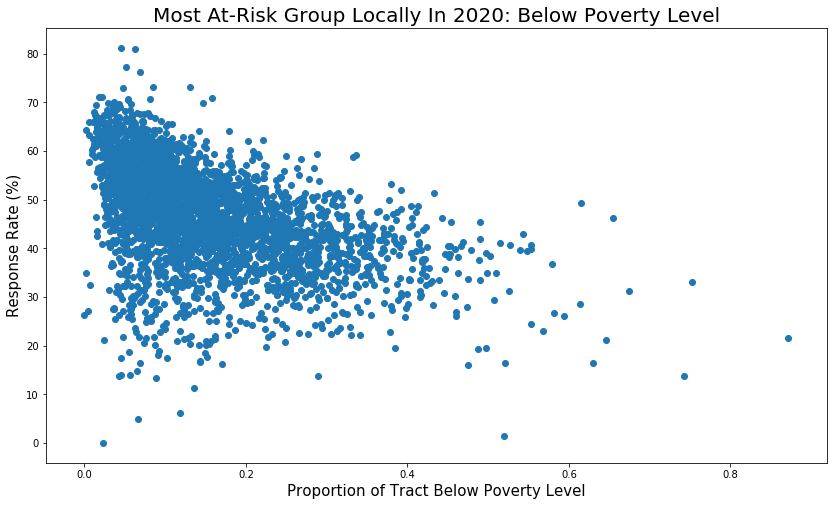

Total Number of Tracts Examined:  3232


In [4]:
show_area(12)

In Florida, we see that response rates seem to have generally worsened significantly in more impoverished, poorly-educated areas, in areas with many non-citizens, and in areas with larger Hispanic populations. 

It's possible that these drops are tied together, and the extreme downturn we've seen in response rates among heavily Hispanic and non-citizen areas are contributing heavily to the economic divides. 

Perhaps this could inspire a further investigation into how the current political climate is affecting the relationship between Florida's Hispanic population and the census.

### Illinois

,correlations_2010,correlations_2020,---------------------,tree_importances_2010,tree_importances_2020
below_poverty_level,-0.71,-0.67,---------------------,0.20,0.51
white,0.70,0.54,---------------------,0.49,0.07
black,-0.60,-0.43,---------------------,0.02,0.02
no_high_school,-0.54,-0.61,---------------------,0.02,0.04
make_over_75k,0.48,0.52,---------------------,0.05,0.10
other_race,-0.32,-0.41,---------------------,0.03,0.02
AIAN,-0.30,-0.14,---------------------,0.04,0.02
hispanic,-0.29,-0.42,---------------------,0.02,0.08
population,0.29,0.29,---------------------,0.04,0.05
noncitizen,-0.25,-0.36,---------------------,0.02,0.02


,Bootstrap P-value of Change in Correlation From 2010 to 2020,Conclusion From P-Value
below_poverty_level,0.002,Increased
white,0.000,Decreased
black,0.000,Increased
no_high_school,0.000,Decreased
make_over_75k,0.001,Increased
other_race,0.000,Decreased
AIAN,0.000,Increased
population,0.472,No Change
hispanic,0.000,Decreased
noncitizen,0.000,Decreased


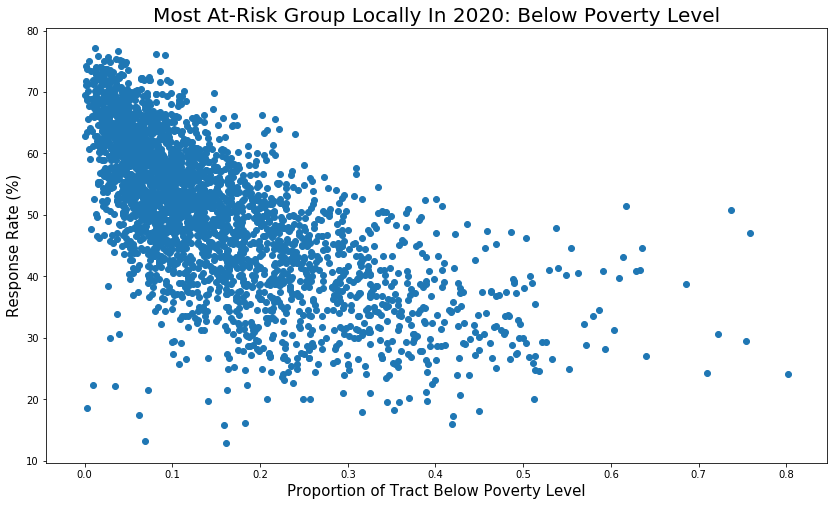

Total Number of Tracts Examined:  2967


In [5]:
show_area(17)

In Illinois, we see absolutely massive divides between whites and African-Americans. However, we can also see an apparent improvement from 2010 to 2020, suggesting that perhaps these gaps in response rates have been mediated slightly. This is not the case for more heavily Hispanic areas, though - just as we would expect after looking at the rest of the country.

We can dig deeper by looking specifically at Cook County, roughly half of whose population makes up the city of Chicago.

### Cook County, IL (Chicago and surrounding areas)

,correlations_2010,correlations_2020,---------------------,tree_importances_2010,tree_importances_2020
below_poverty_level,-0.73,-0.67,---------------------,0.61,0.52
white,0.70,0.51,---------------------,0.10,0.02
black,-0.56,-0.34,---------------------,0.01,0.03
make_over_75k,0.52,0.53,---------------------,0.06,0.11
no_high_school,-0.50,-0.64,---------------------,0.02,0.03
population,0.32,0.28,---------------------,0.04,0.05
AIAN,-0.23,-0.12,---------------------,0.02,0.01
other_race,-0.22,-0.42,---------------------,0.03,0.02
asian,0.19,0.20,---------------------,0.03,0.02
hispanic,-0.17,-0.43,---------------------,0.01,0.12


,Bootstrap P-value of Change in Correlation From 2010 to 2020,Conclusion From P-Value
below_poverty_level,0.003,Increased
white,0.000,Decreased
black,0.000,Increased
make_over_75k,0.282,No Change
no_high_school,0.000,Decreased
population,0.044,No Change
AIAN,0.000,Increased
other_race,0.000,Decreased
asian,0.415,No Change
hispanic,0.000,Decreased


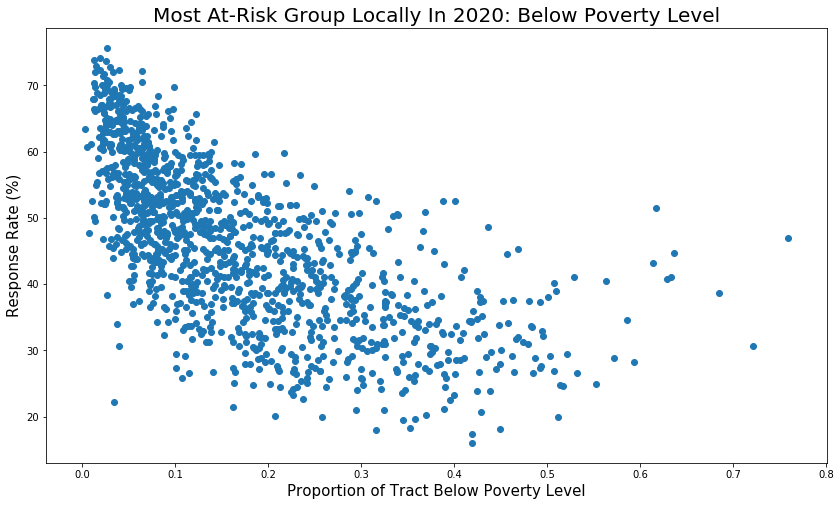

Total Number of Tracts Examined:  1284


In [6]:
show_area(17031)

We see much of the same here, which isn't surprising as Cook County makes up nearly half the population of Illinois.

### Los Angeles County

,correlations_2010,correlations_2020,---------------------,tree_importances_2010,tree_importances_2020
below_poverty_level,-0.49,-0.59,---------------------,0.27,0.37
noncitizen,-0.36,-0.56,---------------------,0.08,0.09
other_race,-0.36,-0.46,---------------------,0.02,0.02
no_high_school,-0.33,-0.52,---------------------,0.03,0.03
asian,0.27,0.35,---------------------,0.09,0.09
hispanic,-0.26,-0.46,---------------------,0.03,0.04
black,-0.26,-0.11,---------------------,0.10,0.03
white,0.25,0.15,---------------------,0.03,0.02
AIAN,-0.23,-0.10,---------------------,0.02,0.02
foreign_born,-0.21,-0.27,---------------------,0.03,0.03


,Bootstrap P-value of Change in Correlation From 2010 to 2020,Conclusion From P-Value
below_poverty_level,0.000,Decreased
other_race,0.000,Decreased
noncitizen,0.000,Decreased
no_high_school,0.000,Decreased
asian,0.000,Increased
black,0.000,Increased
hispanic,0.000,Decreased
white,0.000,Decreased
AIAN,0.000,Increased
foreign_born,0.078,No Change


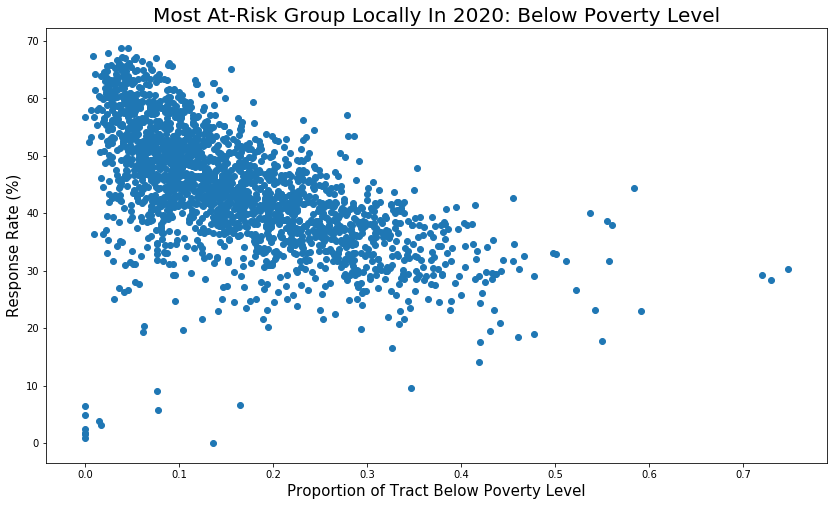

Total Number of Tracts Examined:  1997


In [7]:
show_area('06037')

Los Angeles County has a similar story - the divide between whites and African-Americans has lessened, and response rates among heavier Hispanic and non-citizen communities have plummeted. More heavily Asian communities, meanwhile, appear to be responding well above the typical clip.

This could again be an outstanding jumping off point for a story about the relationship between the Hispanic community and the census, and how it has been affected by the current political climate.

### Louisiana

,correlations_2010,correlations_2020,---------------------,tree_importances_2010,tree_importances_2020
white,0.53,0.04,---------------------,0.25,0.05
black,-0.50,-0.04,---------------------,0.02,0.06
population,0.45,0.31,---------------------,0.26,0.15
make_over_75k,0.44,0.28,---------------------,0.04,0.10
below_poverty_level,-0.39,-0.32,---------------------,0.08,0.25
no_high_school,-0.21,-0.37,---------------------,0.04,0.07
other_race,-0.19,-0.03,---------------------,0.04,0.01
multiracial,-0.14,-0.12,---------------------,0.06,0.04
noncitizen,-0.11,-0.05,---------------------,0.01,0.04
hispanic,-0.11,0.01,---------------------,0.05,0.03


,Bootstrap P-value of Change in Correlation From 2010 to 2020,Conclusion From P-Value
white,0.000,Decreased
black,0.000,Increased
population,0.000,Decreased
make_over_75k,0.000,Decreased
below_poverty_level,0.039,No Change
no_high_school,0.000,Decreased
other_race,0.000,Increased
multiracial,0.232,No Change
hispanic,0.000,Increased
noncitizen,0.029,No Change


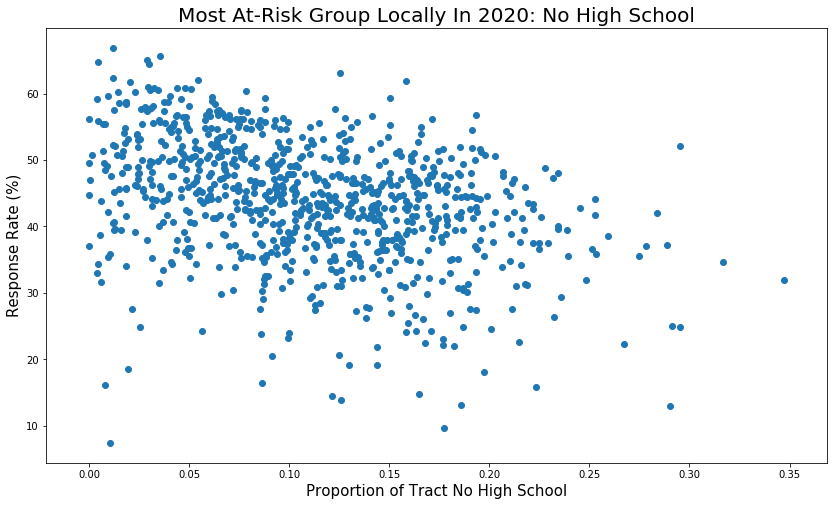

Total Number of Tracts Examined:  890


In [8]:
show_area(22)

Louisiana has a curious, almost unbelievable trend: the disparities in response rates between the heavier-white and heavier-black communities seem to have almost completely disappeared.

This is an extremely odd change, and it's difficult to make sense of. There are nearly 900 tracts in Louisiana, so it doesn't appear to be variation due to sample size. There's no immediate, obvious reason why this might be happening. It could be a bizarre random variation, but perhaps something else is going on here.

It would be a highly interesting trend for a newsroom to investigate.

### Maryland

,correlations_2010,correlations_2020,---------------------,tree_importances_2010,tree_importances_2020
make_over_75k,0.61,0.73,---------------------,0.38,0.53
below_poverty_level,-0.57,-0.70,---------------------,0.14,0.21
no_high_school,-0.51,-0.58,---------------------,0.04,0.02
black,-0.40,-0.50,---------------------,0.05,0.04
white,0.39,0.47,---------------------,0.03,0.03
asian,0.26,0.33,---------------------,0.04,0.01
AIAN,-0.25,-0.08,---------------------,0.02,0.02
population,0.23,0.27,---------------------,0.06,0.05
other_race,-0.20,-0.20,---------------------,0.03,0.01
hispanic,-0.14,-0.15,---------------------,0.03,0.02


,Bootstrap P-value of Change in Correlation From 2010 to 2020,Conclusion From P-Value
make_over_75k,0.000,Increased
below_poverty_level,0.000,Decreased
no_high_school,0.003,Decreased
black,0.002,Decreased
white,0.005,Increased
asian,0.003,Increased
AIAN,0.000,Increased
population,0.098,No Change
other_race,0.499,No Change
hispanic,0.400,No Change


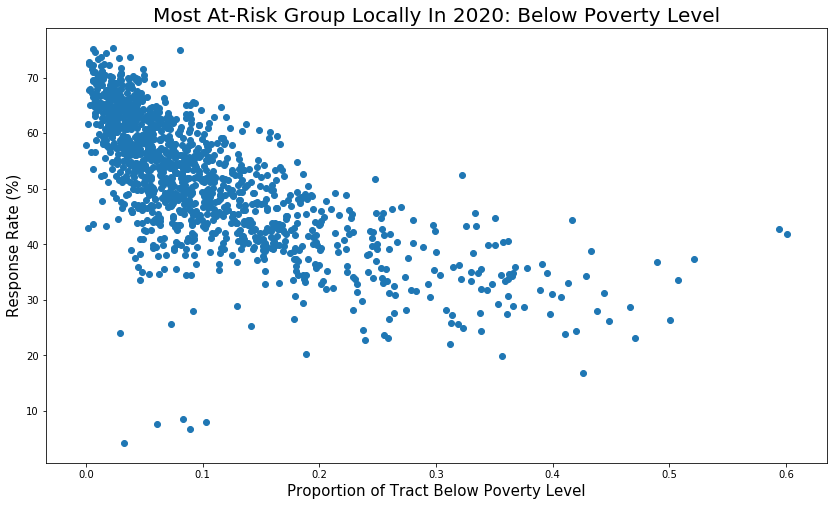

Total Number of Tracts Examined:  1266


In [9]:
show_area(24)

In Maryland, we see massive, worsening divides between the rich and the poor, the educated and the less-educated, as well as most of the typical racial divides - although similarly to Los Angeles County, the more heavily Asian communities appear to be faring better than the norm.

The .73 correlation between number of residents making over \\$75,000 and census response rates in Maryland tells us that 53\% (over half!) of the variation in tract response rates could be accounted for by taking into account just the propoprtion of residents making over \\$75,000 in a tract, and nothing else.

We can look at Baltimore City to zero in on an area with very well-known disparities.

### Baltimore 

,correlations_2010,correlations_2020,---------------------,tree_importances_2010,tree_importances_2020
below_poverty_level,-0.51,-0.66,---------------------,0.37,0.48
make_over_75k,0.42,0.65,---------------------,0.09,0.07
no_high_school,-0.40,-0.58,---------------------,0.14,0.04
population,0.35,0.26,---------------------,0.09,0.09
white,0.34,0.58,---------------------,0.07,0.13
black,-0.28,-0.53,---------------------,0.02,0.03
other_race,-0.23,-0.14,---------------------,0.04,0.02
hispanic,-0.18,-0.07,---------------------,0.01,0.02
AIAN,-0.16,-0.05,---------------------,0.03,0.03
asian,0.08,0.16,---------------------,0.03,0.04


,Bootstrap P-value of Change in Correlation From 2010 to 2020,Conclusion From P-Value
below_poverty_level,0.005,Decreased
make_over_75k,0.000,Increased
no_high_school,0.002,Decreased
population,0.077,No Change
white,0.000,Increased
black,0.000,Decreased
other_race,0.114,No Change
hispanic,0.032,No Change
AIAN,0.069,No Change
asian,0.135,No Change


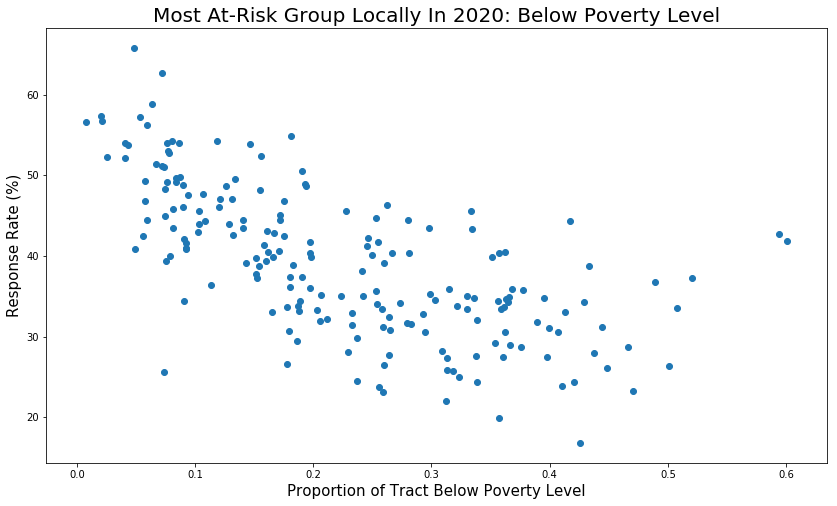

Total Number of Tracts Examined:  196


In [10]:
show_area(24510)

White this is a small sample of tracts, it certaily appears that the rich/poor and white/African-American divides in response rates are growing far worse in Baltimore.

### Montana

,correlations_2010,correlations_2020,---------------------,tree_importances_2010,tree_importances_2020
rural,-0.54,-0.71,---------------------,0.37,0.59
population,0.49,0.59,---------------------,0.06,0.05
AIAN,-0.37,-0.29,---------------------,0.01,0.09
white,0.33,0.24,---------------------,0.17,0.02
asian,0.23,0.22,---------------------,0.00,0.00
make_over_75k,-0.19,0.19,---------------------,0.10,0.02
black,0.19,0.21,---------------------,0.01,0.01
no_high_school,-0.17,-0.27,---------------------,0.03,0.04
multiracial,0.14,0.11,---------------------,0.04,0.01
hispanic,0.11,0.05,---------------------,0.01,0.07


,Bootstrap P-value of Change in Correlation From 2010 to 2020,Conclusion From P-Value
rural,0.000,Decreased
population,0.033,No Change
AIAN,0.343,No Change
white,0.331,No Change
asian,0.429,No Change
black,0.383,No Change
make_over_75k,0.074,No Change
no_high_school,0.065,No Change
multiracial,0.289,No Change
hispanic,0.186,No Change


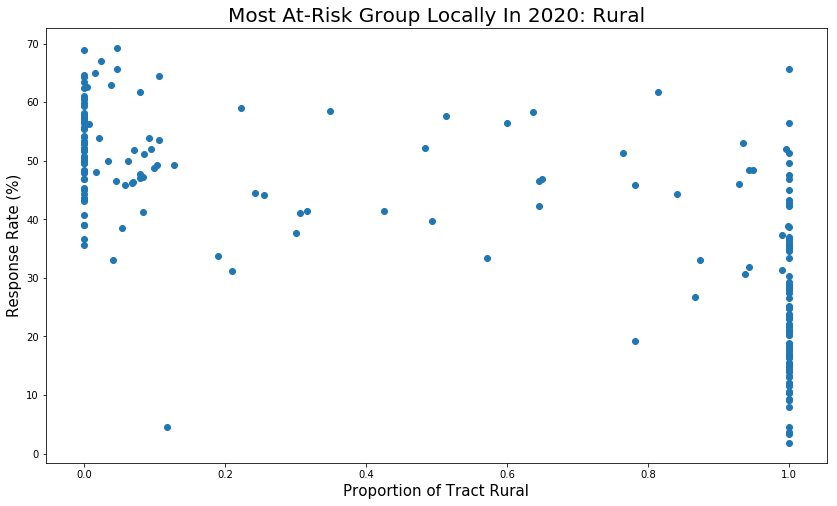

Total Number of Tracts Examined:  208


In [11]:
show_area(30)

In Montana, we see populous areas faring much better than rural areas, and white/black/Asian/Hispanic-heavy areas faring much better than the native-heavy areas. 

While we're again dealing with a small sample size, this does a great job of illustrating the challenge of counting native populations.

### Other States, Counties, etc.

See the section below!

# 3. Adapting This Analysis For Your Newsroom

*NewsCounts* can help you run this analysis for your state (or even county or multi-county region), and determine which factors correlated most with undercounting there. 

We can do this by looking back at 2010, going in-the-moment and looking at why it might be happening right now in 2020, and deducing whether things are getting better or worse.

It is *very* easy for us to pop out these same numbers for just about any level of US geography with a FIPS code. We can do it almost instantaneously - just ask!

We're also quite open to incorporating new data. There are thousands of data points we can add if you feel another demographic factor might be good for modeling why your region is getting undercounted. Drop us a note if you have an idea, and we'll make this work for you.

### Contact Info & Other Resources

Feel free to email me at [benjamin.livingston@columbia.edu](mailto:benjamin.livingston@columbia.edu) or post on the *NewsCounts* Slack channel (email me for an invite) any time if you'd like us to do this for your area.

The Census Bureau is tracking 2020 response rates and provides [a wonderful map with up-to-date data](https://2020census.gov/en/response-rates.html). *NewsCounts* also provides a [beta dashboard](https://newscounts.appspot.com/) and [API](https://bernacho.github.io/NewsCounts-ResponseRatesAPI/API_documentation.html) that allows you to grab the daily response data for yourself. 

[CUNY's hard-to-count map](https://www.censushardtocountmaps2020.us/) is an excellent resource for a general look back at which areas were undercounted in 2010. It's too early to compare 2010 and 2020 response rates tit-for-tat (as this census is far from complete and faces unique challenges [during the COVID-19 outbreak](https://www.census.gov/newsroom/press-releases/2020/statement-covid-19-2020.html), but this tool can give you a feel for how the count is progressing in your area.

Please don't hesistate to reach out with any census reporting-related questions. We recognize this spring is a challenging time for journalists, and we're here to make covering this pivotal census easier for you.

# Appendix: Technical Details

### Running This Analysis For Yourself (if you want to try!)

We're very happy to do this for you, but if you prefer getting your hands on this tool yourself (and you're familiar with Jupyter), just follow these steps and you should be able to replicate this for your area (or multiple areas) in just minutes:
1. Access this notebook in [Google Colab](https://colab.research.google.com/drive/1EDXffZXTY11ikcsdWvV9_jPJ66WECd0V) and copy it over to your Google Drive, or download the notebook from [this project's repo](https://github.com/bwliv/censusresponses/blob/master/undercount_modeling.ipynb) by hitting "raw" and then "save as".
2. Run all this notebook's cells as-is (they should take five minutes or less to run)
3. In the code block below, fill in *show_area(--fips--)* with the FIPS code of the [state](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696) or [county](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697) you want to look up, and run the block.
4. Voilà! You have your up-to-date results.

In [ ]:
show_area()

### Mathematical Nuts & Bolts

**Correlations** estimate how much response rates increase (positive correlation) or decrease (negative correlation) based on the increased presence of a certain subgroup. They range on a constant scale from -1 (perfectly negatively correlated), to 0 (absolutely no linear correlation), to 1 (perfectly positively correlated). These are just linear (Pearson) correlations, so they only measure linear relationships - it's possible a relationship could exist even if we didn't conclude one does here.

Generally, a correlation would need to be at or above .3 or at or below -.3 for us to consider it anything more than weak - but given that most of the groups we're referring to are minorities, we can likely lower that threshold to account for their limited ability to impact response rates as a whole. If, say, a subgroup makes up only 30% of the population, it's unreasonable to expect it to have a drastic impact on overall response rates, and a correlation of .2 may be quite telling (more on this in the caveats section below).

Another way to think about correlations that is **great** for articles is this: if you square them, you get the percent of the variation in response rates that can be explained by the presence of that subgroup alone (again assuming that simple linear model).

For instance, we saw that there is a positive 0.73 correlation between presence of people making over \\$75,000 and census response rates in Maryland. We noted that this meant 53\% of the variation in tract response rates in Maryland could be accounted for by simply factoring in the proportion of people making over \\$75,000 in a given tract, and nothing else.

[**Feature importances**](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_) indicate how important a demographic factor is towards determining how undercounted an area has been relative to other factors. They place a higher priority on weighting the most important factors - unlike correlations, which treat the factors independently.

**Bootstrap p-values** estimate the probability that we would see the correlations we got in 2020 if nothing had changed since 2010. If they're zero (or close to zero), it suggests that the relationship between prevalence of that group and census response rates has changed since 2010. The *lower* the p-value, the more significant the change. We used a 95% level of significance with a two-sided alternative hypothesis.

**Bootstrapping** is a technique that allows us to estimate the distribution of a random sample through sampling with replacement. We do 1,000 bootstrap samples for each of our analyses here; essentially, our analysis asks "if we resampled the 2010 data 1,000 times, what is the probability that we would see the 2020 correlation we got?" If this probability is below .025, we conclude there was a signficant change in correlation from 2010 to 2020.

Technically, our p-values tell us whether or not to reject the null hypothesis that there was no change in a correlation, not actually say that there was a definitive increase or decrease - but for simplicity, we labeled our results as "increase", "decrease", or "no change."

### Statistical Caveats

It's very important to note that these results can partially be traced to the relative sizes of certain subgroups in tracts. Larger subgroups will have naturally have a bigger impact on response rates, so comparing the magnitudes of these results across subgroups isn't particularly useful.

For instance, the impacts of the presence of American Indian / Alaska Native populations seem small, but they are actually difficult to ignore: they are surprisingly large given that this group has a national population of less than 5 million. In Montana, we saw how this impact grew in an area with a larger AIAN population.

Also, because we weighted all tracts equally, this analysis inherently put more emphasis on the characteristics of communities in less populous tracts. However, approximately 95% of census tracts have a population between 1,400 and 7,300, so we don't believe this introduced extreme bias into our data.

### What This Is Not

We are using ACS estimates from 2018 for our 2020 results, and a mix of decennial census numbers and ACS estimates for 2010; this is the best data we have for each period, but it admittedly isn't gospel truth. 

Furthermore, the 2020 demographics are much more of an estimation than the 2010 numbers, given that they're based on 2018 estimates, and not exact 2020 decennial census numbers (which are not available yet).

Additionally, the 2020 census is *far* from done, so these trends could change as it continues.

As a more general point, this analysis provides a general overview of tract-level trends, *not* an exact breakdown of person-level data. We are comparing *areas* that are home to thousands of people by examining the characteristics of those areas, rather than examining the exact characteristics of individual people. 

In short, this is an estimation of trends, not an exact analysis. This is a vital distinction that should be mentioned with any takeaway from this breakdown.